In [1]:
import keras
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import UpSampling2D
from keras.layers import Concatenate
from keras.layers import Lambda 
from keras.utils import to_categorical
import tensorflow as tf
from keras.layers import Add 

from keras.layers import Reshape

from keras import backend as K
from keras import regularizers, optimizers
%matplotlib inline

/home/surya/.conda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [26]:
import scipy.io as scio
import numpy as np    
import os
import matplotlib.pyplot as plt
import math
import re
from scipy.misc import imsave
from scipy import ndimage, misc
from numpy import unravel_index
from operator import sub
import Utility
import cv2

In [3]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger,EarlyStopping,ModelCheckpoint


In [23]:
trainList = ["others","Melanoma/original"]
class_id = 0
class_path = []
segs_path = []
classes = []
imgs_path = []
paths = []
Melanoma = []
for training_name in trainList:
    class_path = Utility.imlist(training_name)
    paths += class_path
    classes += [class_id] * len(class_path)
    class_id += 1
    if(class_id>1):
        class_id=1

In [24]:
path = "gt"
gt_paths = []
for pt in paths:
    #print(pt)
    newfile = pt.split("/")[-1][0:-4]+ "_segmentation.png"
    newpath = path+"/" + newfile
    #print (newpath)
    gt_paths.append(newpath)

In [27]:
norm_images = []
seg_images = []
for i in range(len(paths)):
    im = cv2.imread(paths[i])
    seg = cv2.imread(gt_paths[i],0)
    norm_images.append(im)
    seg_images.append(seg)

In [29]:
n_images = np.array(norm_images)
s_images = np.array(seg_images)

In [30]:
x_train  = n_images[:1500]
x_test  =  n_images[1500:]
y_train = s_images[:1500]
y_test =  s_images[1500:]

In [7]:
rows = 256
cols = 256

data_shape = 216*64
weight_decay = 0.0001

In [8]:
# Defines the input tensor
inputs = Input(shape=(None,None,3))

L1 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(inputs)
L2 = BatchNormalization()(L1)
L2 = Activation('relu')(L2)
#L3 = Lambda(maxpool_1,output_shape = shape)(L2)
L3 = MaxPooling2D(pool_size=(2,2))(L2)
L4 = Conv2D(128,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L3)
L5 = BatchNormalization()(L4)
L5 = Activation('relu')(L5)
#L6 = Lambda(maxpool_2,output_shape = shape)(L5)
L6 = MaxPooling2D(pool_size=(2,2))(L5)
L7 = Conv2D(128,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L6)
L8 = BatchNormalization()(L7)
L9 = Activation('relu')(L8)
L10 = Conv2D(128,(3,3),dilation_rate= (2,2), padding = "same", activation='relu', name = "conv_dil_1")(L9)
L11 = BatchNormalization()(L10)
L12 = Activation('relu')(L11)
L13 = Conv2D(128,(3,3),dilation_rate= (4,4), padding = "same", activation='relu', name = "conv_dil_2")(L12)
L14 = BatchNormalization()(L13)
L15 = Activation('relu')(L14)
L16 = Conv2D(128,(3,3),dilation_rate= (8,8), padding = "same", activation='relu', name = "conv_dil_3")(L15)
L17 = BatchNormalization()(L16)
L18 = Activation('relu')(L17)
L19 = Conv2D(128,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay),
             name="skip_conv_1")(L6)
L20 = Add()([L18,L19])
L21 = UpSampling2D( size = (2,2)) (L20)
#L21 = Deconvolution2D(128, kernel_size = (3,3), strides = (2,2), activation = "relu", 
 #                     name = "ct_deconv_1", padding = "same")(L20)
L21 = Conv2D(128,(3,3), padding = "same", kernel_regularizer=regularizers.l2(weight_decay))(L21)
L22 = BatchNormalization()(L21)
L23 = Activation('relu')(L22)
L24 = Conv2D(128,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay),
             name="skip_conv_2")(L3)
L24 = Add()([L23,L24])
L25 = UpSampling2D(size = (2,2))(L24)
L25 = Conv2D(64, (3,3), padding = "same", kernel_regularizer=regularizers.l2(weight_decay))(L25)
#L25 = Deconvolution2D(64, kernel_size = (3,3), strides = (2,2), activation = "relu", 
 #                     name = "ct_deconv_2", padding = "same")(L24)
#L25 = 
L26 = BatchNormalization()(L25)
L27 = Activation('relu')(L26)
L28 = Conv2D(1,kernel_size=(1,1),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L27)#

L30 = Activation('sigmoid')(L28)
model = Model(inputs = inputs, outputs = L30)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 6 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 6 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [9]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [10]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [11]:
def customized_loss(y_true,y_pred):
    return (1*K.binary_crossentropy(y_true, y_pred))+(0.5*dice_coef_loss(y_true, y_pred))

In [13]:
y_train = y_train.reshape(y_train.shape[0],256,256,1)
y_test = y_test.reshape(y_test.shape[0],256,256,1)
smooth = 1
optimiser = optimizers.Adam(lr = 0.01)


model.compile(optimizer=optimiser,loss=dice_coef_loss,metrics=['accuracy',dice_coef])
model.fit(x_train,y_train,batch_size=16,epochs=10,validation_data=(x_test, y_test),verbose=1)

Train on 1500 samples, validate on 500 samples
Epoch 1/10
1500/1500 [==============================] - 6447s 4s/step - loss: -0.5412 - acc: 0.8490 - dice_coef: 0.6171 - val_loss: -0.0754 - val_acc: 0.8200 - val_dice_coef: 0.1318
Epoch 2/10
1500/1500 [==============================] - 6411s 4s/step - loss: -0.6376 - acc: 0.8941 - dice_coef: 0.7121 - val_loss: -0.3494 - val_acc: 0.8622 - val_dice_coef: 0.4292
Epoch 3/10
1500/1500 [==============================] - 6501s 4s/step - loss: -0.7311 - acc: 0.9200 - dice_coef: 0.7831 - val_loss: -0.0622 - val_acc: 0.8155 - val_dice_coef: 0.0934
Epoch 4/10
1500/1500 [==============================] - 6439s 4s/step - loss: -0.7700 - acc: 0.9257 - dice_coef: 0.7993 - val_loss: -0.0492 - val_acc: 0.8141 - val_dice_coef: 0.0773
Epoch 5/10
1500/1500 [==============================] - 6539s 4s/step - loss: -0.7796 - acc: 0.9303 - dice_coef: 0.8094 - val_loss: -0.6099 - val_acc: 0.8517 - val_dice_coef: 0.6392
Epoch 6/10
1500/1500 [=====================

KeyboardInterrupt: 

In [18]:
img = y_test[10].reshape((256,256))

In [19]:
test = x_test[10].reshape((1,256,256,3))
pred = model.predict(test)
test_img = pred.reshape((256,256))

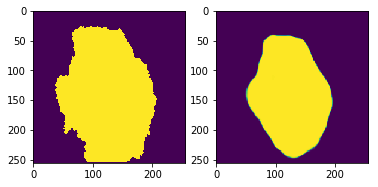

In [20]:
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(test_img)